# Using `ipyparallel`

Parallel execution is tightly integrated with Jupyter in the `ipyparallel` package. Install with

```bash
pip install ipyparallel
```

This is a rich framework. For more on how to use `ipyparallel`, see

[Official documentation](https://ipyparallel.readthedocs.org/en/latest/)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Starting engines

We will only use engines on local cores which does not require any setup - see [docs](https://ipyparallel.readthedocs.org/en/latest/process.html) for detailed instructions on how to set up a remote cluster, including setting up to use Amazon EC2 clusters.

You can start a cluster on the `IPython Clusters` tab in the main Jupyter browser window 

The main advantage of developing parallel applications using `ipyparallel` is that it can be done interactively within Jupyter.

## Basic concepts of `ipyparallel`

In [2]:
from ipyparallel import Client

The client connects to the cluster of "remote" engines that perfrom the actual computation. These engines may be on the same machine or on a cluster. 

In [3]:
rc = Client()

In [4]:
rc.ids

[0, 1, 2, 3]

A view provides access to a subset of the engines available to the client. Jobs are submitted to the engines via the view. A direct view allows the user to explicitly send work specific engines. The load balanced view is like the `Pool` object in `multiprocessing`, and manages the scheduling and distribution of jobs for you.

**Direct view**

In [5]:
dv = rc[:]

Add 10 sets of 3 numbers in parallel using all engines.

In [6]:
dv.map_sync(lambda x, y, z: x + y + z, range(10), range(10), range(10))

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

Add 10 sets of 3 numbers in parallel using only alternate engines.

In [7]:
rc[::2].map_sync(lambda x, y, z: x + y + z, range(10), range(10), range(10))

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

Add 10 sets of 3 numbers using a specific engine.

In [8]:
rc[2].map_sync(lambda x, y, z: x + y + z, range(10), range(10), range(10))

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

**Load balanced view**

Use this when you have many jobs that take different amounts of time to complete.

In [9]:
lv = rc.load_balanced_view()

In [10]:
lv.map_sync(lambda x: sum(x), np.random.random((10, 100000)))

[49965.41659502253,
 49974.97622055525,
 50124.15695856495,
 49953.43449687519,
 49997.73421604095,
 49856.747844696656,
 49975.55435079295,
 50053.28712551892,
 50001.60344667205,
 49948.125345066124]

#### Calling functions with apply

In contrast to `map`, `apply` is just a simple function call run on all remote engines, and has the usual function signature `apply(f, *args, **kwargs)`. It is a primitive on which other more useful functions (such as `map`) are built upon.

In [11]:
rc[1:3].apply_sync(lambda x, y: x**2 + y**2, 3, 4)

[25, 25]

In [12]:
rc[1:3].apply_sync(lambda x, y: x**2 + y**2, x=3, y=4)

[25, 25]

### Synchronous and asynchronous jobs

We have used the `map_sync` and `apply_sync` methods. The `sync` suffix indicate that we want to run a synchronous job. Synchronous jobs `block` until all the computation is done and return the result.

In [13]:
res = dv.map_sync(lambda x, y, z: x + y + z, range(10), range(10), range(10))

In [14]:
res

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

In contrast, asynchronous jobs return immediately so that you can do other work, but returns a `AsyncMapResult` object, similar to the `future` object returned by the `concurrent.futures` package. You can query its status, cancel running jobs and retrieve results once they have been computed.

In [15]:
res = dv.map_async(lambda x, y, z: x + y + z, range(10), range(10), range(10))

In [16]:
res

<AsyncMapResult: <lambda>:finished>

In [17]:
res.done()

True

In [18]:
res.get()

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

There is also a `map` method that by default uses asynchronous mode, but you can change this by setting the `block` attribute or function argument.

In [19]:
res = dv.map(lambda x, y, z: x + y + z, range(10), range(10), range(10))

In [20]:
res.get()

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

Change blocking mode for just one job.

In [21]:
res = dv.map(lambda x, y, z: x + y + z, range(10), range(10), range(10), block=True)

In [22]:
res

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

Change blocking mode for this view so that all jobs are synchronous.

In [23]:
dv.block = True

In [24]:
res = dv.map(lambda x, y, z: x + y + z, range(10), range(10), range(10))

In [25]:
res

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]


### Remote function decorators 

The `@remote` decorator results in functions that will execute simultaneously on all engines in a view. For example, you can use this decorator if you always want to run $n$ independent parallel MCMC chains.

In [26]:
with dv.sync_imports():
    import numpy

importing numpy on engine(s)


In [33]:
@dv.remote(block = True)
def f1(n):
    return numpy.random.rand(n)

In [34]:
f1(4)

[array([0.34202282, 0.99332378, 0.37978469, 0.89301744]),
 array([0.29406015, 0.5588737 , 0.45749659, 0.0812964 ]),
 array([0.3540588 , 0.46972006, 0.83054545, 0.84040124]),
 array([0.80525307, 0.76837497, 0.11848167, 0.39623938])]

The @parallel decorator breaks up elementwise operations and distributes them.

In [35]:
@dv.parallel(block = True)
def f2(x):
    return x

In [36]:
f2(range(15))

[range(0, 4), range(4, 8), range(8, 12), range(12, 15)]

In [37]:
@dv.parallel(block = True)
def f3(x):
    return sum(x)

In [38]:
f3(range(15))

[6, 22, 38, 39]

In [39]:
@dv.parallel(block = True)
def f4(x, y):
    return x + y

In [40]:
f4(np.arange(10), np.arange(10))

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])

####  Example: Use the `@parallel` decorator to speed up Mandelbrot calculations

In [41]:
def mandel1(x, y, max_iters=80):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

In [42]:
@dv.parallel(block = True)
def mandel2(x, y, max_iters=80):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

In [43]:
x = np.arange(-2, 1, 0.01)
y = np.arange(-1, 1, 0.01)
X, Y = np.meshgrid(x, y)

In [44]:
%%time
im1 = np.reshape(list(map(mandel1, X.ravel(), Y.ravel())), (len(y), len(x)))

CPU times: user 536 ms, sys: 0 ns, total: 536 ms
Wall time: 537 ms


In [45]:
%%time
im2 = np.reshape(mandel2.map(X.ravel(), Y.ravel()),  (len(y), len(x)))

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 223 ms


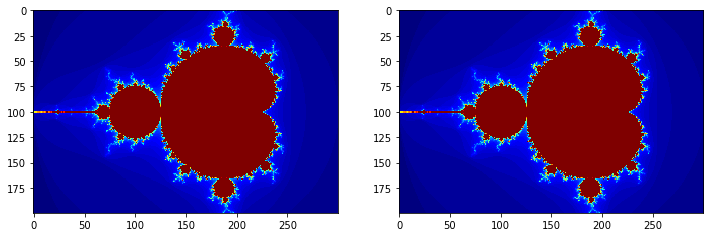

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].grid(False)
axes[0].imshow(im1, cmap='jet')
axes[1].grid(False)
axes[1].imshow(im2, cmap='jet')
pass

### Functions with dependencies

Modules imported locally are NOT available in the remote engines.

In [47]:
import time
import datetime

In [48]:
def g1(x):
    time.sleep(0.1)
    now = datetime.datetime.now()
    return (now, x)

This fails with an Exception because the `time` and `datetime` modules are not imported in the remote engines.

```python
dv.map_sync(g1, range(10))
```

The simplest fix is to import the module(s) *within* the function

In [49]:
def g2(x):
    import time, datetime
    time.sleep(0.1)
    now = datetime.datetime.now()
    return (now, x)

In [50]:
dv.map_sync(g2, range(5))

[(datetime.datetime(2020, 3, 24, 20, 27, 5, 412229), 0),
 (datetime.datetime(2020, 3, 24, 20, 27, 5, 512389), 1),
 (datetime.datetime(2020, 3, 24, 20, 27, 5, 413791), 2),
 (datetime.datetime(2020, 3, 24, 20, 27, 5, 417799), 3),
 (datetime.datetime(2020, 3, 24, 20, 27, 5, 417902), 4)]

Alternatively, you can simultaneously import both locally and in the remote engines with the `sync_import` context manager.

In [51]:
with dv.sync_imports():
    import time
    import datetime

importing time on engine(s)
importing datetime on engine(s)


Now the `g1` function will work.

In [52]:
dv.map_sync(g1, range(5))

[(datetime.datetime(2020, 3, 24, 20, 27, 20, 424798), 0),
 (datetime.datetime(2020, 3, 24, 20, 27, 20, 524974), 1),
 (datetime.datetime(2020, 3, 24, 20, 27, 20, 424902), 2),
 (datetime.datetime(2020, 3, 24, 20, 27, 20, 425218), 3),
 (datetime.datetime(2020, 3, 24, 20, 27, 20, 425608), 4)]

Finally, there is also a `require` decorator that can be used. This will force the remote engine to import all packages given.

In [53]:
from ipyparallel import require

In [54]:
@require('scipy.stats')
def g3(x):
    return scipy.stats.norm(0,1).pdf(x)

In [55]:
dv.map(g3, np.arange(-3, 4))

[0.0044318484119380075,
 0.05399096651318806,
 0.24197072451914337,
 0.3989422804014327,
 0.24197072451914337,
 0.05399096651318806,
 0.0044318484119380075]

### Moving data around

We can send data to remote engines with `push` and retrieve them with `pull`, or using the dictionary interface. For example, you can use this to distribute a large lookup table to all engines once instead of repeatedly as a function argument.

In [56]:
dv.push(dict(a=3, b=2))

[None, None, None, None]

In [57]:
def f(x):
    global a, b
    return a*x + b

In [58]:
dv.map_sync(f, range(5))

[2, 5, 8, 11, 14]

In [59]:
dv.pull(('a', 'b'))

[[3, 2], [3, 2], [3, 2], [3, 2]]

#### You can also use the dictionary interface as an alternative to push and pull

In [60]:
dv['c'] = 5

In [61]:
dv['a']

[3, 3, 3, 3]

In [62]:
dv['c']

[5, 5, 5, 5]

Using parallel magic commands
----

In practice, most users will simply use the `%px` magic to execute code in parallel from within the notebook. This is the simplest way to use `ipyparallel`.

In [63]:
def f(xs):
    s = 0
    for x in xs:
        s += x
    return s

In [64]:
dv.map(f, np.random.random((6, 4)))

[1.697714371911632,
 2.328592931577743,
 1.3925610691588357,
 2.9859226219564965,
 2.7817541121634646,
 2.8616612692066195]

### %px

This sends the command to all targeted engines.

In [65]:
%px import numpy as np
%px a = np.random.random(4)
%px a.sum()

Out[0:3]: 1.108072268829341

Out[1:3]: 2.4772735435461546

Out[2:3]: 2.0954671242075573

Out[3:3]: 1.931252710786763

#### List comprehensions in parallel

The `scatter` method partitions and distributes data to all engines. The `gather` method does the reverse. Together with `%px`, we can simulate parallel list comprehensions.

In [66]:
dv.scatter('a', np.random.randint(0, 10, 10))
%px print(a)

[stdout:0] [7 5 0]
[stdout:1] [7 1 4]
[stdout:2] [2 5]
[stdout:3] [6 5]


In [67]:
dv.gather('a')

array([7, 5, 0, 7, 1, 4, 2, 5, 6, 5])

In [68]:
dv.scatter('xs', range(24))
%px y = [x**2 for x in xs]
np.array(dv.gather('y'))

array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529])

#### Running magic functions in parallel

[output:1]

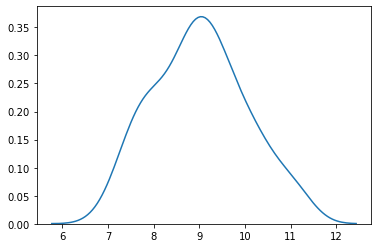

[output:3]

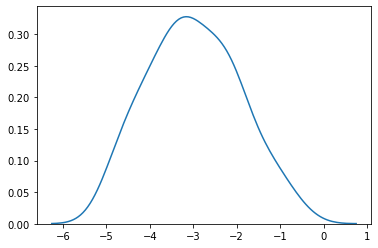

In [69]:
%%px --target [1,3]
%matplotlib inline
import seaborn as sns
x = np.random.normal(np.random.randint(-10, 10), 1, 100)
sns.kdeplot(x);

### Running in non-blocking mode

In [70]:
%%px --target [1,3] --noblock
%matplotlib inline
import seaborn as sns
x = np.random.normal(np.random.randint(-10, 10), 1, 100)
sns.kdeplot(x);

<AsyncResult: execute>

[output:1]

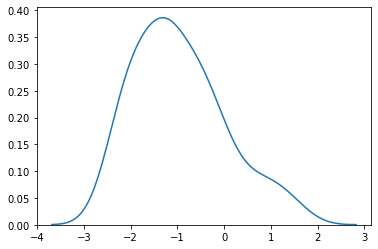

[output:3]

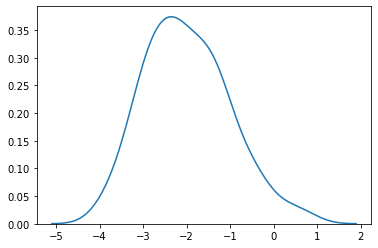

In [71]:
%pxresult